# Visualizing Ballots
We've just gone over reading and cleaning ballots from real-world voting records and generating ballots using a variety of models. In this section, we turn to visualizing ballots in a variety of ways.

## Summary Statistics

VoteKit comes with some summary statistics built in for analyzing ballots. For this, we will introduce the **Impartial Culture** and **Impartial Anonymous Culture** models of ballot generation, which are frequently used in social choice scholarly literature, even though they are far less realistic and flexible than the models we ran above!  

Impartial Culture (IC) is essentially the $\alpha=\infty$ extreme of the family of Dirichlet measures [from earlier](2_real_and_simulated_profiles.html#dirichlet-distribution); that is, the probability of each ranking is set exactly equal.  Impartial Anonymous Culture (IAC) is the $\alpha=1$ ("all bets are off") case.

In [1]:
from votekit.plots import plot_summary_stats
import votekit.ballot_generator as bg

# generate a profile to work with first
candidates = ["A", "B", "C"]

# initializing the ballot generator
ic = bg.ImpartialCulture(candidates=candidates)
iac = bg.ImpartialAnonymousCulture(candidates=candidates)

profile1 = ic.generate_profile(number_of_ballots = 1000)
profile2 = iac.generate_profile(number_of_ballots=1000)

print('IC profile:')
print(profile1)
print()
print('IAC profile:')
print(profile2)

IC profile:
  Ballots Weight
(B, A, C)    173
(C, B, A)    172
(A, C, B)    170
(B, C, A)    170
(C, A, B)    162
(A, B, C)    153

IAC profile:
  Ballots Weight
(B, C, A)    388
(B, A, C)    254
(A, B, C)    135
(A, C, B)    103
(C, A, B)     62
(C, B, A)     58


Now we'll plot some summary statistics for the generated elections.  

- ``first place votes`` will measure how many first place votes each candidate received.

- ``borda`` reports the **Borda score** of each candidate. If there are $n$ candidates on a ballot, the first place candidate gets $n$ points, the second $n-1$, and so on.

- ``mentions`` simply counts the number of times candidates were listed at all.  Note that if we use generative methods that produce complete rankings, everyone will necessarily have the same number of mentions!

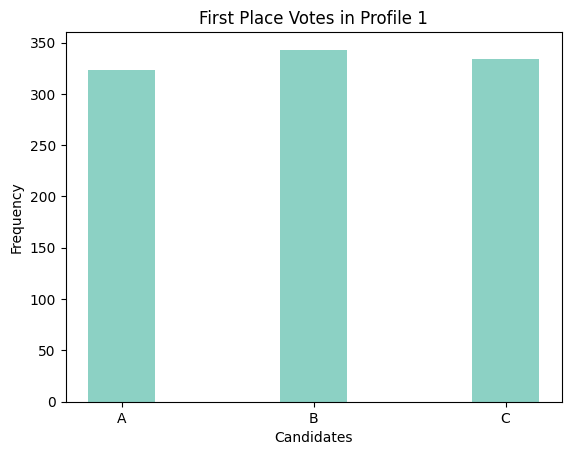

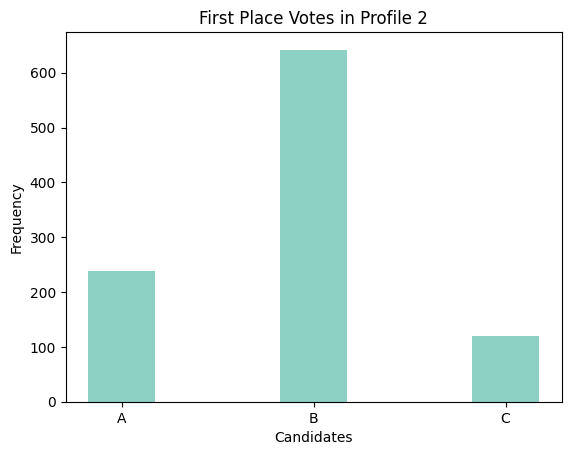

In [2]:
fig1 = plot_summary_stats(profile1, "first place votes", multi_color = False, 
                          title = "First Place Votes in Profile 1")
fig2 = plot_summary_stats(profile2, "first place votes", multi_color = False, 
                          title = "First Place Votes in Profile 2")


### **Try it yourself**
> Change the statistic from `first place votes` to `borda` and then `mentions`. Change the title of the plot accordingly. Change the `multicolor` parameter to True to see what it does.  Give them appropriate titles.

## Pairwise Comparison Graph

The pairwise comparison graph is used for examining head to head contests. Each vertex of the graph is a candidate. If there is an edge going from $A$ to $B$, that means $A$ is preferred to $B$ more times in the profile. The weight on the edge is the number of times $A$ is preferred to $B$ minus the number of times $B$ is preferred to $A$.

PreferenceProfile too long, only showing 15 out of 97 rows.
         Ballots Weight
(W1, W2, C2, C1)     73
        (W1, W2)     70
(W1, W2, C1, C2)     62
           (W1,)     58
    (W1, W2, C2)     44
(W1, C2, W2, C1)     40
(W1, C2, C1, W2)     34
        (W2, W1)     32
    (W1, C2, W2)     26
    (W1, W2, C1)     25
(W2, W1, C2, C1)     23
(C2, W2, W1, C1)     23
(W2, W1, C1, C2)     22
(W1, C1, C2, W2)     21
    (W2, W1, C1)     21


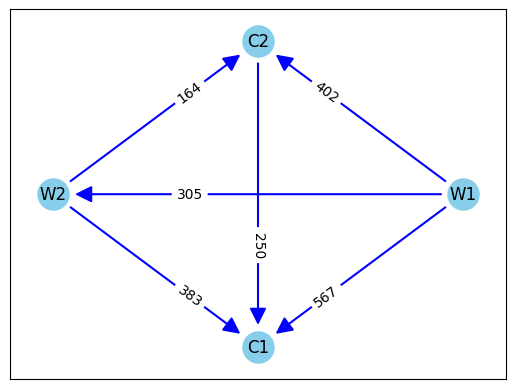

In [3]:
from votekit.graphs import PairwiseComparisonGraph

bloc_voter_prop = {"W": .8, "C": .2}

# the values of .9 indicate that these blocs are highly polarized;
# they prefer their own candidates much more than the opposing slate
cohesion_parameters = {"W": {"W":.9, "C":.1},
                       "C": {"C":.9, "W":.1}}

dirichlet_alphas = {"W": {"W":2, "C":1},
                    "C": {"W":1, "C":.5}}

slate_to_candidates = {"W": ["W1", "W2"],
                        "C": ["C1", "C2"]}

cs = bg.CambridgeSampler.from_params(slate_to_candidates=slate_to_candidates,
          bloc_voter_prop=bloc_voter_prop,
          cohesion_parameters=cohesion_parameters,
          alphas=dirichlet_alphas)

profile = cs.generate_profile(number_of_ballots= 1000)
print(profile)

pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()

Again, due to randomization, do not expect your graph labels to exactly match the one pictured in the tutorial. 


The `PairwiseComparisonGraph` has methods for computing dominating tiers and the existence of a Condorcet winner (one who beats every other candidate head-to-head). A **dominating tier** is a group of candidates that beats every lower-tier candidate in a head-to-head comparison.



In [4]:
# dominating tiers
print('tiers:',pwc_graph.dominating_tiers())

# condorcet winner
if pwc_graph.has_condorcet_winner() == True:
  print("The Condorcet candidate is:",pwc_graph.get_condorcet_winner())
else:
  print("There is no Condorcet candidate.  The top tier is:",
        pwc_graph.dominating_tiers()[0])

tiers: [{'W1'}, {'W2'}, {'C2'}, {'C1'}]
The Condorcet candidate is: W1


## MDS Plots

One of the coolest features of VoteKit (in the humble opinion of this tutorial author) is that we can create multidimensional scaling (MDS) plots, using different notions of distance between `PreferenceProfiles`. A multidimensional scaling plot (MDS) is a 2D representation of high-dimensional data that attempts to minimize the distortion of the data. VoteKit comes with two kinds of distance metrics:  earth-mover distance and  $L_p$ distance. You can read about these in the [VoteKit documentation](../../social_choice_docs/scr.html#distances-between-preferenceprofiles).

Let's explore how an MDS plot can provide a powerful visualization. First we will initialize our generators.

In [5]:
from votekit.plots import plot_MDS, compute_MDS
from votekit.metrics import earth_mover_dist, lp_dist
from votekit import PreferenceInterval

number_of_ballots = 100

slate_to_candidates = {"all_voters": ["A", "B", "C"]}

prefs1 = {"all_voters": {"all_voters": PreferenceInterval({"A": .8, "B":.15, "C":.05})}}
prefs2 = {"all_voters": {"all_voters": PreferenceInterval({"A": .1, "B":.5, "C":.4})}}  

bloc_voter_prop = {"all_voters": 1}
cohesion_parameters = {"all_voters": {"all_voters": 1}}

pl1 = bg.name_PlackettLuce(slate_to_candidates = slate_to_candidates,
                      bloc_voter_prop = bloc_voter_prop,
                     pref_intervals_by_bloc = prefs1,
                     cohesion_parameters=cohesion_parameters)

pl2 = bg.name_PlackettLuce(slate_to_candidates = slate_to_candidates,
                      bloc_voter_prop = bloc_voter_prop,
                     pref_intervals_by_bloc = prefs2,
                     cohesion_parameters=cohesion_parameters)

bt1 = bg.name_BradleyTerry(slate_to_candidates = slate_to_candidates,
                      bloc_voter_prop = bloc_voter_prop,
                     pref_intervals_by_bloc = prefs1,
                     cohesion_parameters=cohesion_parameters)

bt2 = bg.name_BradleyTerry(slate_to_candidates = slate_to_candidates,
                      bloc_voter_prop = bloc_voter_prop,
                     pref_intervals_by_bloc = prefs2,
                     cohesion_parameters=cohesion_parameters)

We have uncoupled the computation and plotting features since the computation is often time intensive, and this allows users to fiddle with the plot without recomputing the coordinates.

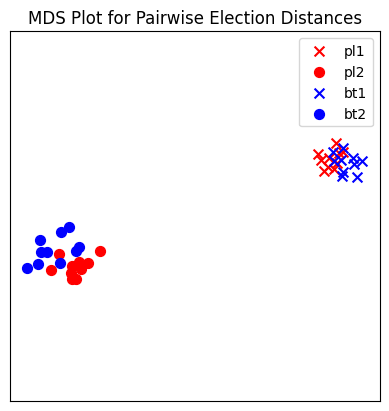

In [6]:
import matplotlib.pyplot as plt
# the data is a dictionary whose keys correspond to data labels
# and whose values are lists of PreferenceProfiles
coord_dict = compute_MDS(data = 
                         {'pl1': [pl1.generate_profile(number_of_ballots) 
                                         for i in range(10)],
                        'pl2': [pl2.generate_profile(number_of_ballots) 
                                for i in range(10)],
                        'bt1': [bt1.generate_profile(number_of_ballots) 
                                for i in range(10)],
                        'bt2': [bt2.generate_profile(number_of_ballots) 
                                for i in range(10)],
                          }, 
            distance = earth_mover_dist)




# we pass the computed coordinates, as well as a nested dictionary of plot parameters
# that will be passed to matplotlib scatter
ax = plot_MDS(coord_dict=coord_dict, 
                plot_kwarg_dict={"pl1":{"c": "red", "s": 50, "marker": "x"},
                                 "pl2":{"c": "red", "s": 50, "marker": "o"},
                                 "bt1":{"c": "blue", "s": 50, "marker": "x"},
                                 "bt2":{"c": "blue", "s": 50, "marker": "o"}},
                legend = True, title = True)


In this plot, each red mark represents a simulated election built from 1000 PL ballots, and each blue mark is likewise 1000 BT ballots, using the same preference interval. The marker, x or o, denotes the preference interval type.  It's very important to remember that the x axis and y axis numbers do not mean ANYTHING in an MDS plot---there's literally a randomized algorithm throwing the 40 points into the plane in a manner that keeps similar things close and puts dissimilar things farther away. That is why our MDS function does not include any axis labels.

What is this plot telling us? The fact that x's are in one area and o's are in another tells us that the different preference intervals generate distinct profiles. Moreover, the fact that the red and blue models have little overlap shows that PL and BT are actually distinguishable as styles of ranking. This is encouraging!

### **Try it yourself**
> Increase the size of each profile to 1000 ballots instead of 100; then there's more opportunity for the differences between PL and BT to emerge. Make the preference intervals more similar or more different; the picture will change accordingly.


## Ballot Graph

The last tool we want to introduce for analyzing ballots is the ballot graph. Each vertex of the ballot graph is a ballot (either a full linear ranking or a partial one). An edge goes between two ballots if they either differ by one candidate at the end of the ballot, or by swapping two adjacent candidates.

We can either initialize the ballot graph from a list of candidates, a number of candidates, or a preference profile. Let's start with a list of candidates first. The `allow_partial` parameter tells the graph to allow incomplete ballots, so when set to `False` it only shows the $n!$ permutations of the $n$ candidates.

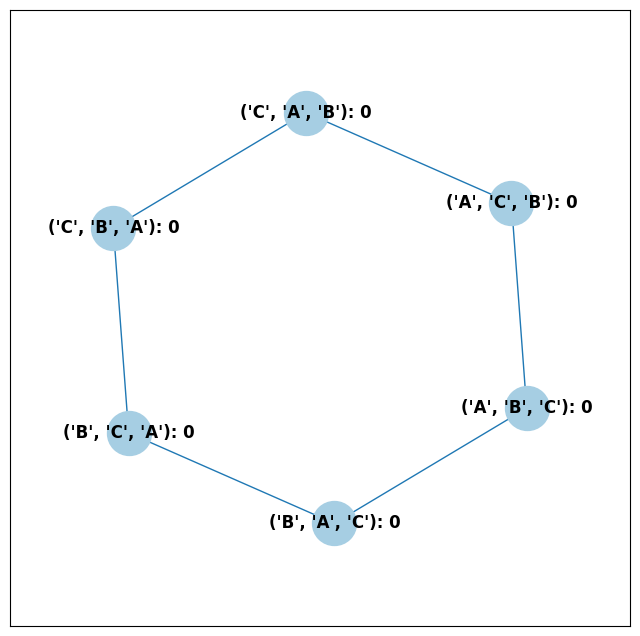

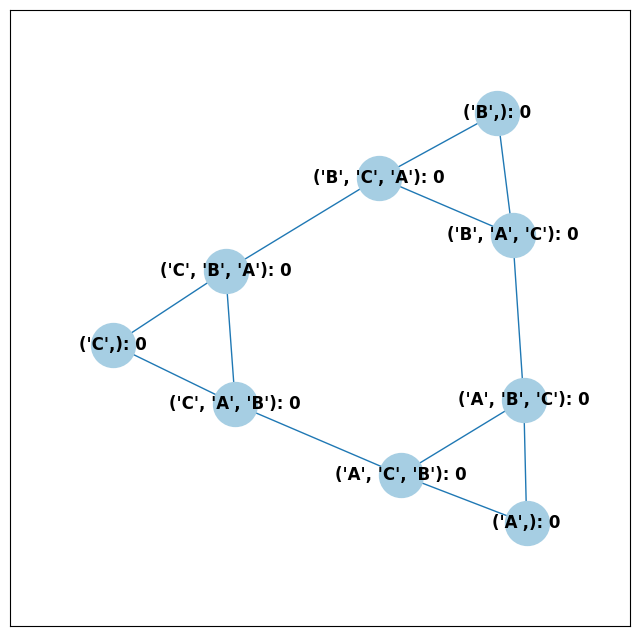

In [7]:
from votekit.graphs import BallotGraph
candidates = ["A", "B", "C"]

ballot_graph = BallotGraph(candidates, allow_partial=False)
ballot_graph.draw(labels= True)

ballot_graph = BallotGraph(candidates, allow_partial=True)
ballot_graph.draw(labels= True)

When we set `labels=True`, the ballot graph displays the candidate names, as well as the number of votes cast on that ballot. Since this graph was not constructed from a `PreferenceProfile`, the number of votes is 0.

You might be wondering where any of the ballots of length 2 are. Currently, the ballot graph takes any ballot that lists all but one candidate and fills in the final candidate. (This might not be how you want it to behave, and we have plans to implement a version where the ballot $A>B$ is distinct from $A>B>C$.)

The `BallotGraph` class has a `graph` attribute which stores the underlying `networkx` graph. The `networkx` graph is indexed by integers; the method `_number_cands` returns a dictionary that converts candidate names to these integers.

In [8]:
print('candidate dictionary:',ballot_graph._number_cands(cands = tuple(candidates)))
print()

for node, data in ballot_graph.graph.nodes(data = True):
    print("node",node)
    print(data)
    print()

candidate dictionary: {'A': 1, 'B': 2, 'C': 3}

node (1,)
{'weight': 0, 'cast': False}

node (1, 2, 3)
{'weight': 0, 'cast': False}

node (1, 3, 2)
{'weight': 0, 'cast': False}

node (2,)
{'weight': 0, 'cast': False}

node (2, 3, 1)
{'weight': 0, 'cast': False}

node (2, 1, 3)
{'weight': 0, 'cast': False}

node (3,)
{'weight': 0, 'cast': False}

node (3, 1, 2)
{'weight': 0, 'cast': False}

node (3, 2, 1)
{'weight': 0, 'cast': False}



The weight attribute would store the number of ballots (if the data came from an election), and the `cast` attribute stores whether or not that ballot appeared in the profile, i.e., returns `True` if the weight is non-zero.



Now let's generate a ballot graph from election data.

  Ballots Weight
(C, B, A)    772
(C, A, B)    121
(B, C, A)     48
(A, C, B)     47
(A, B, C)      8
(B, A, C)      4


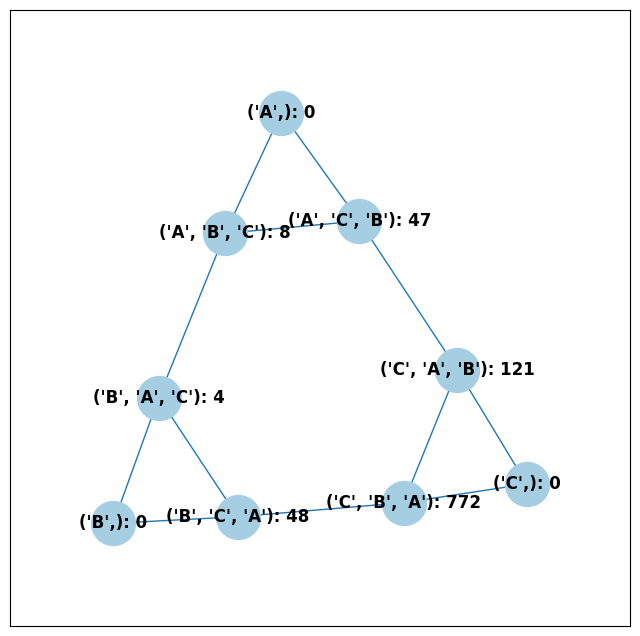

(1,) {'weight': 0, 'cast': False}
(1, 2, 3) {'weight': Fraction(4, 1), 'cast': True}
(1, 3, 2) {'weight': Fraction(48, 1), 'cast': True}
(2,) {'weight': 0, 'cast': False}
(2, 3, 1) {'weight': Fraction(47, 1), 'cast': True}
(2, 1, 3) {'weight': Fraction(8, 1), 'cast': True}
(3,) {'weight': 0, 'cast': False}
(3, 1, 2) {'weight': Fraction(772, 1), 'cast': True}
(3, 2, 1) {'weight': Fraction(121, 1), 'cast': True}


In [9]:
candidates  = ["A", "B", "C"]

iac = bg.ImpartialAnonymousCulture(candidates = candidates)

profile = iac.generate_profile(number_of_ballots= 1000)
print(profile)

ballot_graph = BallotGraph(profile)
ballot_graph.draw(labels= True,show_cast=False)

for node, data in ballot_graph.graph.nodes(data = True):
    print(node,data)

Check that this is reasonable: only ballots that were in the `PreferenceProfile` should have `cast = True`, and their `weight` attribute should correspond to the number of ballots cast. Why do none of the bullet votes appear in the profile?

### **Try it yourself**
> If we wanted to visualize only the nodes corresponding to cast ballots, we use the `show_cast = True` parameter in the `draw` method. You can go back and try that above.

 What if we wanted to explore a particular neighborhood of a ballot? Let's look at the radius-1 neighborhood around the ballot (3,2,1,4). This is also called the *1-neighborhood*, and it means (3,2,1,4) and its immediate neighbors, with their interconnections shown.  The 0-neighborhood is only a point itself; the 2-neighborhood is everything within two steps on the ballot graph.

Here we will initialize the ballot graph from a number, representing the number of candidates. The scale parameter allows us to better visualize the crowded graph.

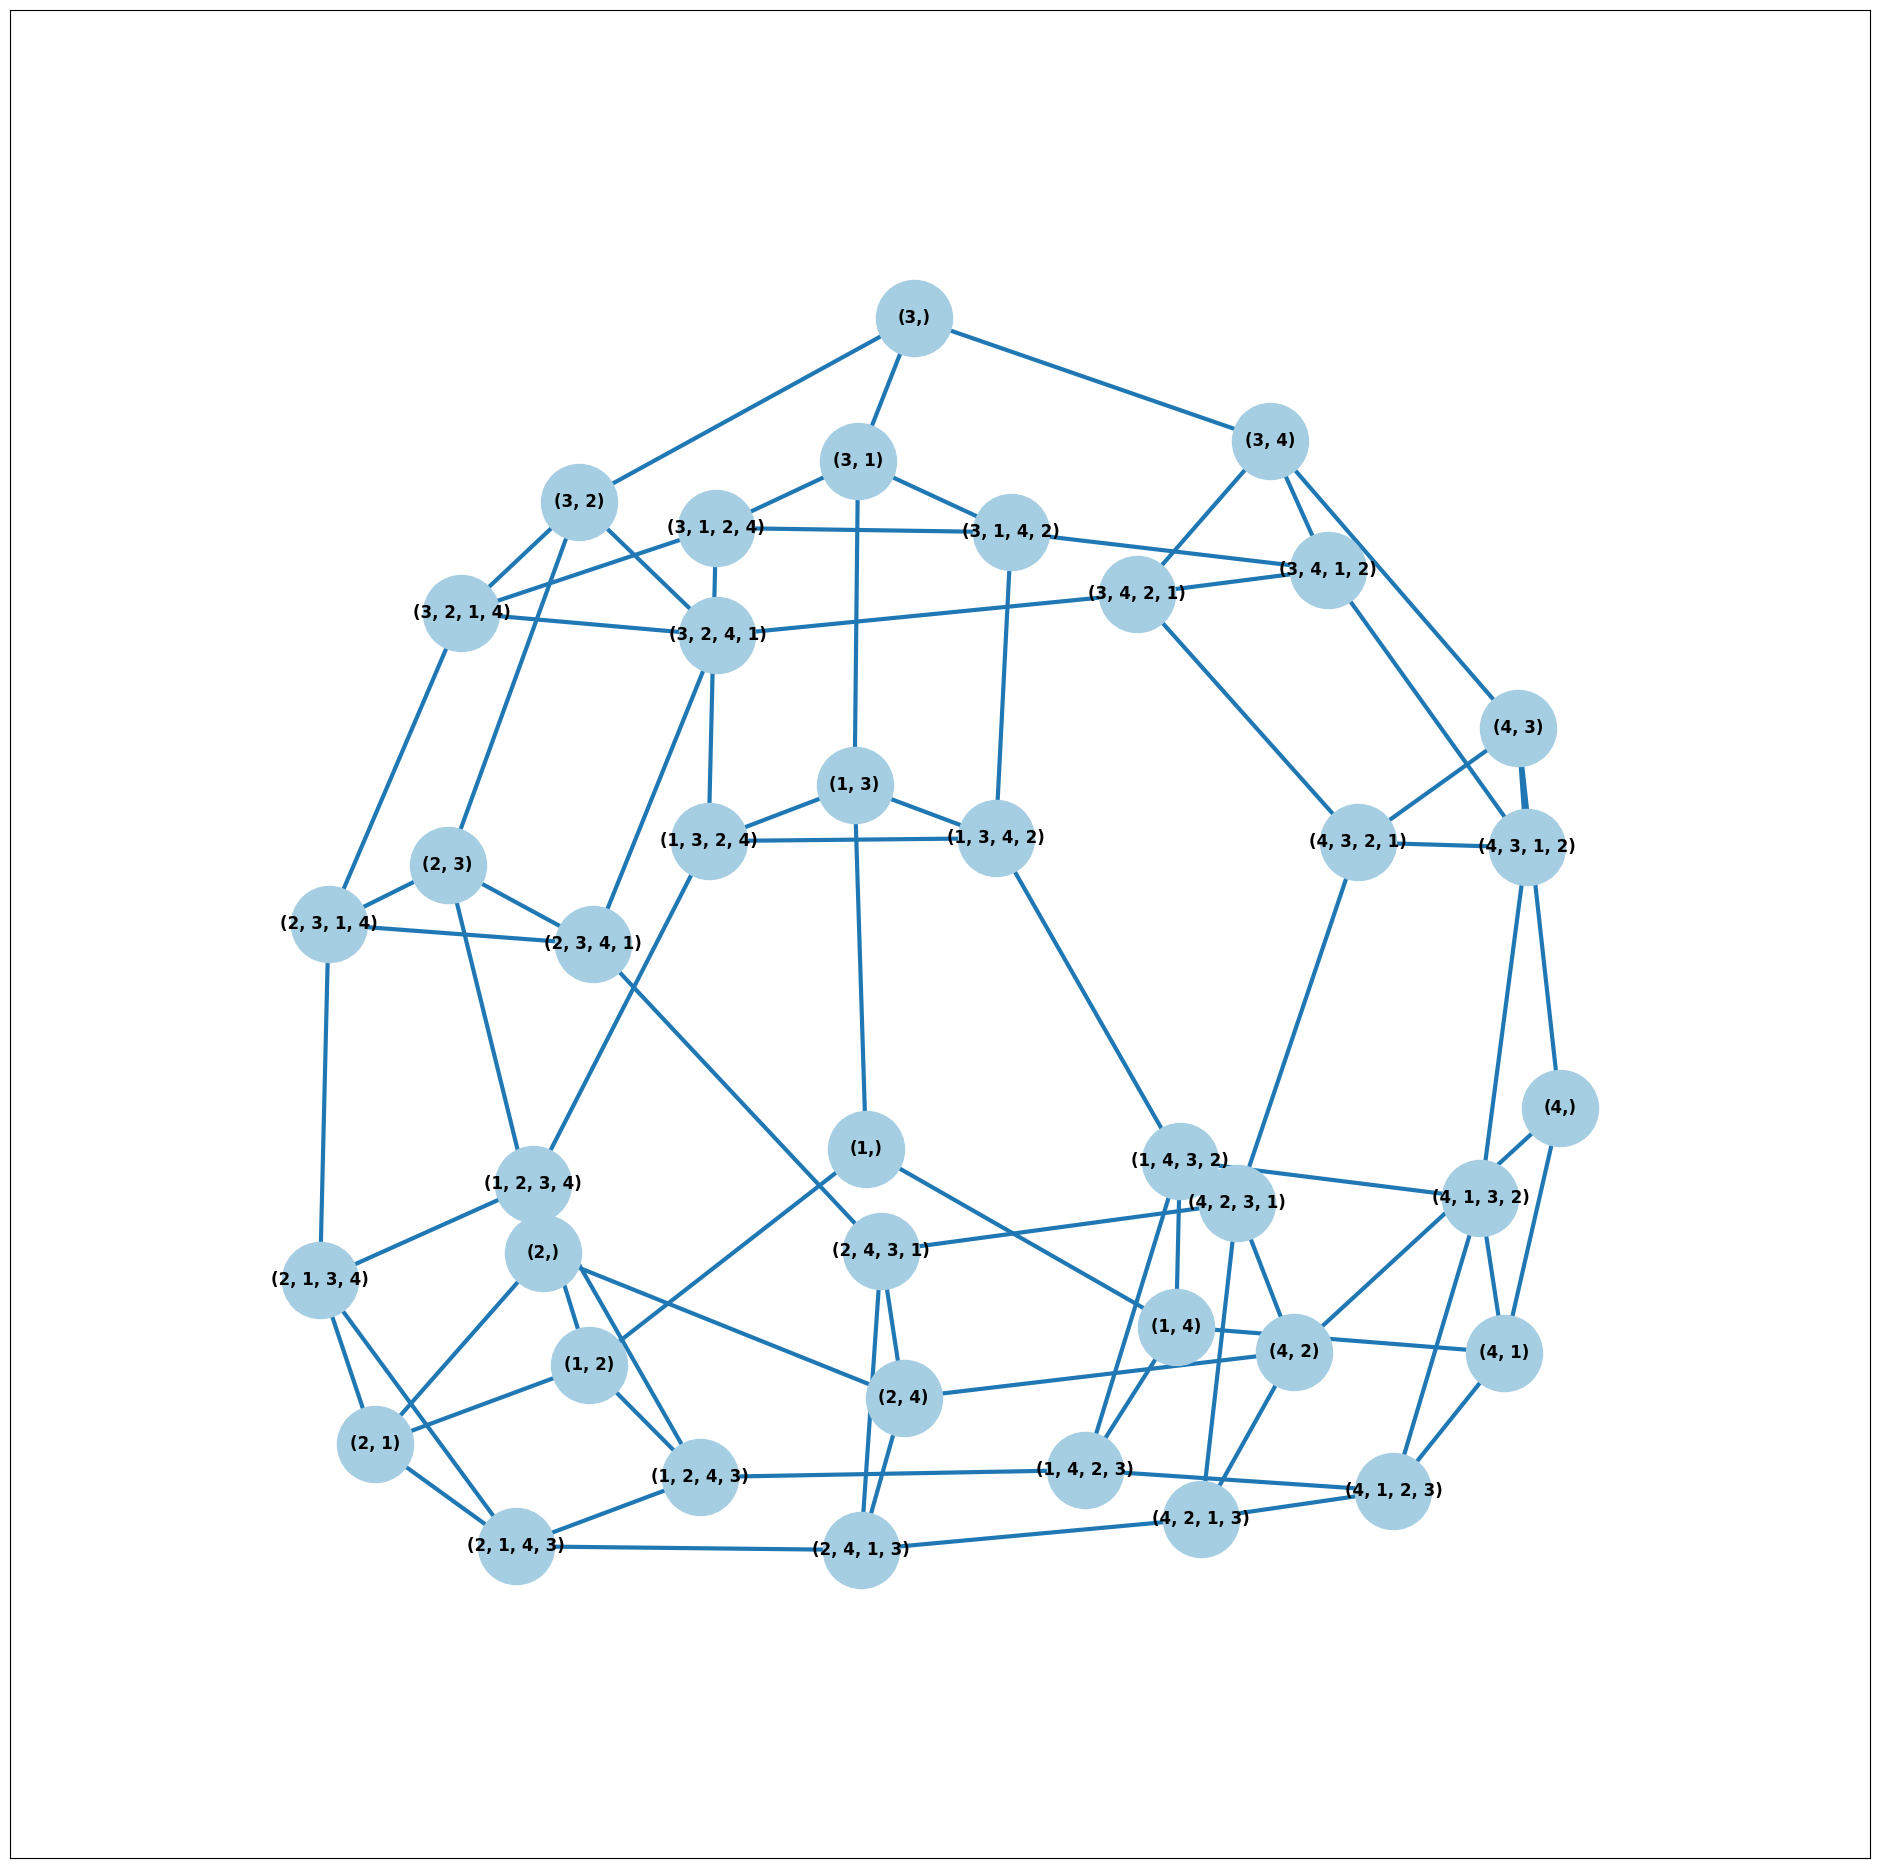

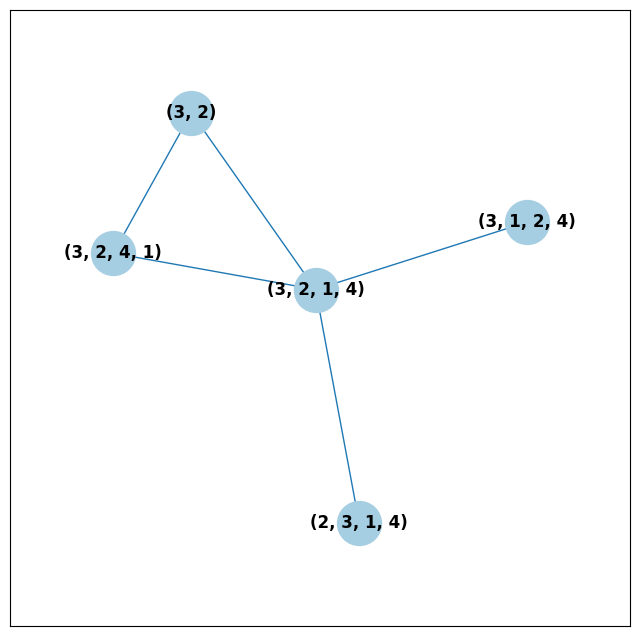

In [10]:
ballot_graph = BallotGraph(4)
ballot_graph.draw(scale=3)

# the neighborhoods parameter takes a list of tuples (node, radius)
# and displays the corresponding neighborhoods
ballot_graph.draw(neighborhoods=[((3,2,1,4), 1)])

We can also draw multiple neighborhoods.

### **Try it yourself**
> In addition to the 1-neighborhood of (3,2,1,4), draw the 1-neighborhood of (2,).  Note that you have to write (2,) and not simply (2) to designate the node with a bullet vote for candidate 2.

## Scottish Elections

Scottish elections give us a great source for real-world ranked data, because STV is used for local government elections.  Thanks to [David McCune](https://www.jewell.edu/faculty/david-mccune) of William Jewell College, we have a fantastic [repository](https://github.com/mggg/scot-elex) of shiny, clean ranking data from over 1000 elections, which feature 3-14 candidates apiece, running with a party label.  

Here we load in the CVR from a ward in Comhairle nan Eilean Siar in 2012, in the election for city council. Please download the csv file [here](https://github.com/mggg/scot-elex/blob/main/4_cands/eilean_siar_2012_ward3.csv) and place it in your working directory (the same folder as your code).

PreferenceProfile too long, only showing 15 out of 57 rows.
                                                                      Ballots Weight
                                                       (Catherine Macdonald,)    155
            (Catherine Macdonald, Philip Robert Mclean, David Cameron Wilson)     74
                                  (Catherine Macdonald, Philip Robert Mclean)     63
                                            (Catherine Macdonald, D J Macrae)     52
                                 (Philip Robert Mclean, David Cameron Wilson)     48
                                  (Philip Robert Mclean, Catherine Macdonald)     36
            (Philip Robert Mclean, David Cameron Wilson, Catherine Macdonald)     31
                      (Catherine Macdonald, D J Macrae, Philip Robert Mclean)     29
                      (Catherine Macdonald, Philip Robert Mclean, D J Macrae)     27
                                                      (Philip Robert Mclean,)     24
(Cath

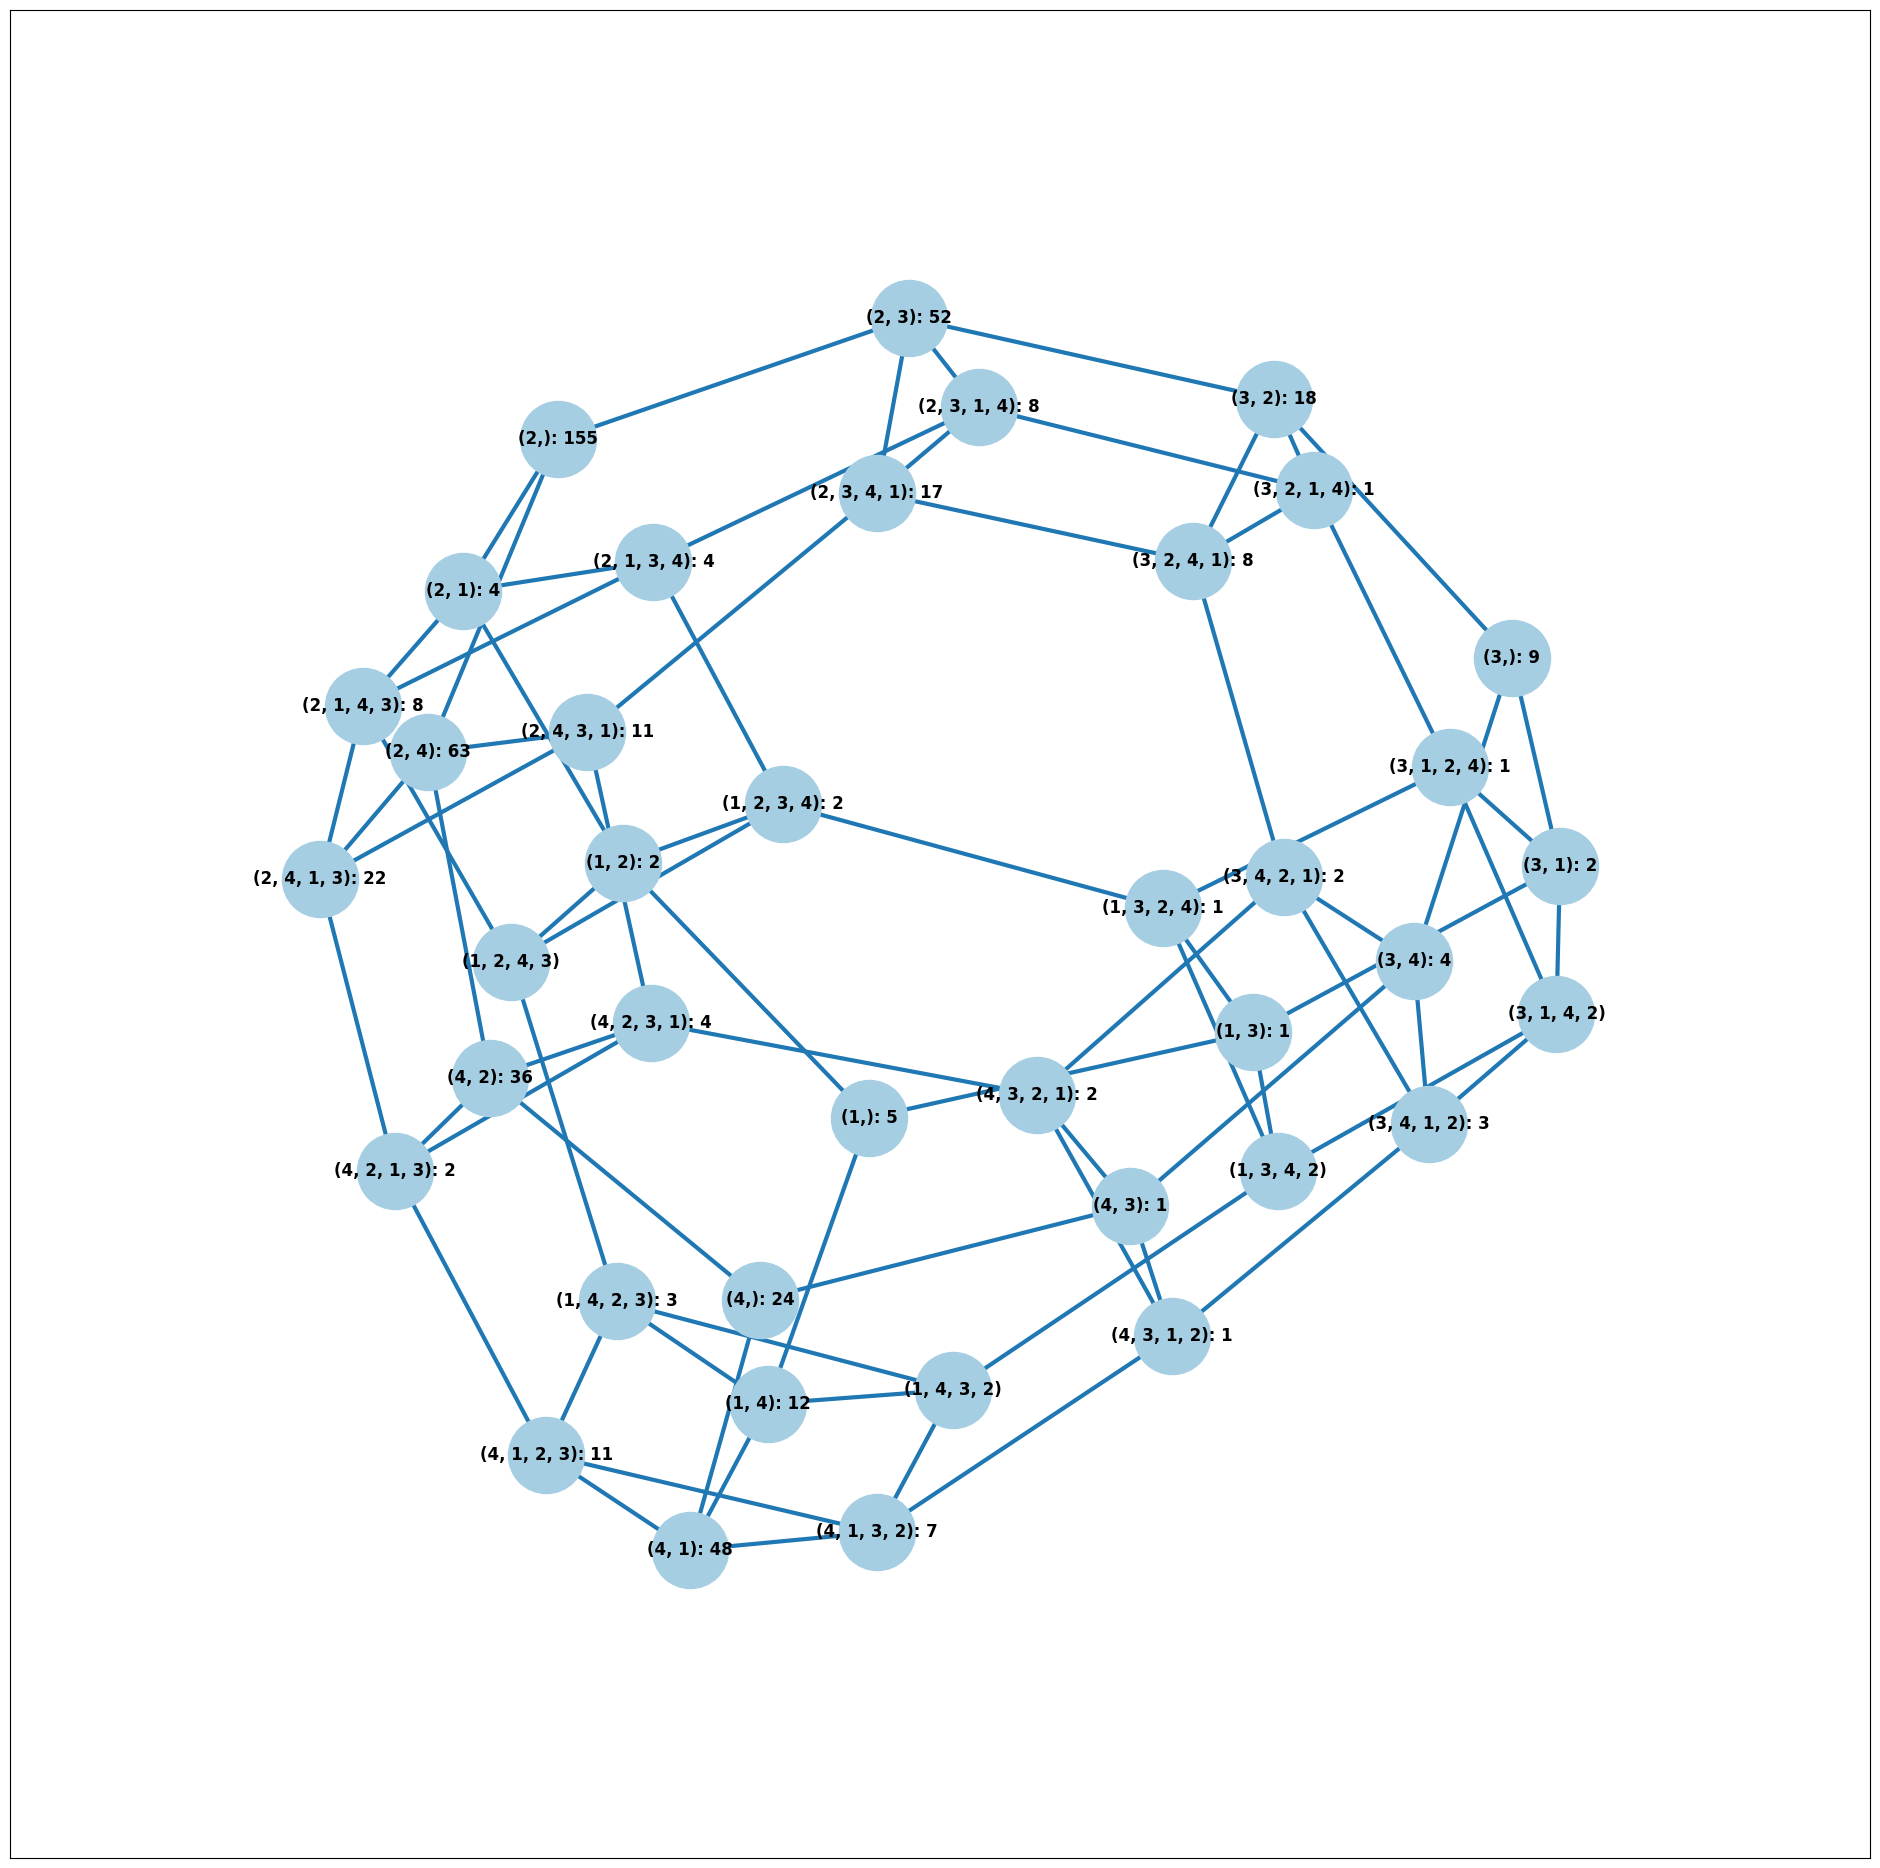

In [5]:
from votekit.cvr_loaders import load_scottish
from votekit.graphs import BallotGraph

# the load_scottish function returns a tuple of information:
# the first element is the profile itself, the second is the number of seats in the election
# the third is a list of candidates, the fourth a dictionary mapping candidatess to parties,
# and the fourth the ward name
scottish_profile, seats, cand_list, cand_to_party, ward = load_scottish("eilean_siar_2012_ward3.csv")


# we don't want to alter any ballots so we'll turn off "fix_short"
ballot_graph = BallotGraph(scottish_profile, fix_short = False)

print(scottish_profile)


# only show us the ballots cast
ballot_graph.draw(show_cast = False,labels = False, scale=3)

There are 64 possible ballots in an election with 4 candidates (65 if you count the empty ballot). How many of those ballots types are missing in this example? Let's figure out which ones. VoteKit allows you to create custom display functions for the ballot graph. These functions must take a `networkx` graph and node as input and return `True` if you want to display the node.

Displaying missing ballots:
The candidates are labeled as follows.
1 David Cameron Wilson
2 Catherine Macdonald
3 D J Macrae
4 Philip Robert Mclean


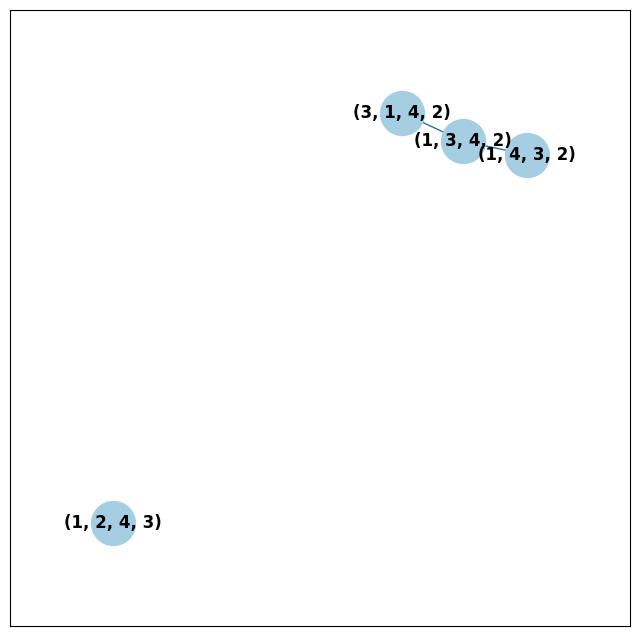

In [3]:
def show_zero(graph, node):
    # display nodes with no votes
    if graph.nodes[node]["weight"] == 0:
        return True
    return False

print("Displaying missing ballots:")
ballot_graph.draw(labels=False, to_display=show_zero)

## Further Prompts

- Generate profiles on three candidates in a manner that is reasonably likely to result in a **Condorcet cycle**, in which there is no Condorcet winner because the arrows go around in, well, a cycle.  
- Make MDS plots that include `ImpartialCulture` and `CambridgeSampler` simulations in addition to PL and BT.
- We have also implemented `lp_dist` as an alternative to `earth_mover_dist`. The $L_p$ distance is parameterized by $p\in (0, \infty]$. It defaults to $p=1$. If we want another value for $p$ we will need to use the `partial` function from the `functools` module. (If you want $p=\infty$, type `p_value="inf"`.)


In [13]:
from functools import partial

# this code is what you would give to the distance parameter 
# if you wanted something other than p=1
distance = partial(lp_dist, p_value=47)

- Generate a ballot graph from a `PreferenceProfile` so we can see how these attributes change. Create a profile with 3 candidates using the `ImpartialCulture` model. To create the ballot graph from a profile, simply pass it in as `BallotGraph(profile)`. Print your profile, display the ballot graph, and print out the data of each node. Confirm that these all match!
- Write a custom display function for a ballot graph to display ballots that have more than 30 votes.